# Fundamentals of Machin Learning
## Project 2: Deep learning. Landscape classification

### Imports

In [2]:
import os
import numpy as np
import pandas as pd
import random as rd

import matplotlib.pyplot as plt
import plotly.express as px

import tensorflow as tf

from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### Data loading function

In [8]:
labels = class_names = ['Coast', 'Desert', 'Forest', 'Glacier', 'Mountain']

def dataframer(base_dir):
    path = []
    label = []
    for img_class in os.listdir(base_dir):
      label_path = os.path.join(base_dir, img_class)
      if img_class in labels:
        for img in os.listdir(label_path):
          path.append(os.path.join(label_path, img))
          label.append(img_class)
    img_data = pd.DataFrame({'Path': path, 'Label': label})
    return img_data

### Parameters and data

In [9]:
SHAPE = (180, 180, 3)
SIZE = (180, 180)

dataset_directory = 'landscape_classification'
dir_path_train = dataset_directory + "/training_data"
dir_path_valid = dataset_directory + "/validation_data"
dir_path_test = dataset_directory + "/testing_data"

train_img_data = dataframer(dir_path_train)
validation_img_data = dataframer(dir_path_valid)
test_img_data = dataframer(dir_path_test)


In [4]:
# Class Distribution
class_dis = [len(os.listdir(dir_path_train + "/" + name)) for name in class_names]

# Visualize
# fig = px.pie(names=class_names, values=class_dis, title="Training Class Distribution", hole=0.4)
# fig.update_layout({'title':{'x':0.5}})
# fig.show()
# fig

# fig = px.bar(x=class_names, y=class_dis, color=class_names)
# fig.show()

In [17]:
def show_images(data, class_names=class_names, model=None, size=(25,25), GRID=[6,6]):

    # Plot Configuration
    n_rows, n_cols = GRID
    n_images = n_rows * n_cols
    plt.figure(figsize=size)

    # Iterate through the data
    rows = data.sample(n = n_images)


    i = 1
    for path, label in rows.values:

        img = tf.keras.utils.load_img(
            path,
            grayscale=False,
            color_mode='rgb',
            target_size=None,
        )

        # Make Prediction 
        if model is not None:
            new_image = img.resize(SIZE)

            x = image.img_to_array(new_image)
            x = x.astype('float64')
            x /= 255.0
            x = np.expand_dims(x, axis=0)

            pred = model.predict(x)[0]
            score = np.round(max(pred),2)
            pred_class = class_names[np.argmax(pred)]

            title = f"True : {label}\nPred : {pred_class}\n Score : {score}"
        else:
            title = label

        plt.subplot(n_rows, n_cols, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(title)

        i+=1

    plt.show()

show_images(train_img_data, GRID=(3, 3), size=(15, 15))

In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1/255,
    zoom_range = 0.1,
    horizontal_flip = True
)

validation_datagen = ImageDataGenerator(
    rescale = 1/255
)

In [7]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_img_data,
    x_col = "Path",
    y_col = "Label",
    target_size = SIZE,
    batch_size = 1024,
    class_mode = "categorical",
    subset = "training",
    shuffle = True,
    seed = 10
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe = validation_img_data,
    x_col = "Path",
    y_col = "Label",
    target_size = SIZE,
    batch_size = 256,
    class_mode = "categorical",
    shuffle = False
)

Found 10000 validated image filenames belonging to 5 classes.
Found 1500 validated image filenames belonging to 5 classes.


### Model preparation

In [8]:
inception = InceptionV3(weights = 'imagenet', include_top = False, input_shape = SHAPE)

for layer in inception.layers[:-5]:
    layer.trainable = False

inception_model = Sequential([
        inception,
        GlobalAveragePooling2D(),
        Flatten(),
        Dense(256, activation = "relu"),
        Dense(128, activation = "relu"),
        Dense(64, activation = "relu"),
        Dense(5, activation = 'softmax')
    ])

inception_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                        

In [9]:
inception_model.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics = ["accuracy"])

In [10]:
checkpoint = ModelCheckpoint('kaggle/working/inception.hdf5', monitor = 'val_accuracy', save_best_only = True)

In [11]:
rd.seed(150)
np.random.seed(150)
tf.random.set_seed(150)

### TRAINING

In [12]:
inception_history = inception_model.fit(
    train_generator,
    steps_per_epoch = 10,
    validation_data = validation_generator,
    validation_steps = 5,
    epochs = 15,
    callbacks = [checkpoint])

Epoch 1/15
10/10 [==============================] - 125s 12s/step - loss: 1.1424 - accuracy: 0.5742 - val_loss: 0.8307 - val_accuracy: 0.7297
Epoch 2/15
10/10 [==============================] - 118s 12s/step - loss: 0.6461 - accuracy: 0.7775 - val_loss: 0.6180 - val_accuracy: 0.7898
Epoch 3/15
10/10 [==============================] - 113s 11s/step - loss: 0.5451 - accuracy: 0.8079 - val_loss: 0.6377 - val_accuracy: 0.7781
Epoch 4/15
10/10 [==============================] - 124s 12s/step - loss: 0.4874 - accuracy: 0.8296 - val_loss: 0.6255 - val_accuracy: 0.7852
Epoch 5/15
10/10 [==============================] - 121s 12s/step - loss: 0.4598 - accuracy: 0.8367 - val_loss: 0.6228 - val_accuracy: 0.7859
Epoch 6/15
10/10 [==============================] - 125s 12s/step - loss: 0.4418 - accuracy: 0.8464 - val_loss: 0.5816 - val_accuracy: 0.8094
Epoch 7/15
10/10 [==============================] - 123s 12s/step - loss: 0.4203 - accuracy: 0.8522 - val_loss: 0.5821 - val_accuracy: 0.8078
Epoch 

In [3]:
model = load_model('kaggle/working/inception.hdf5')

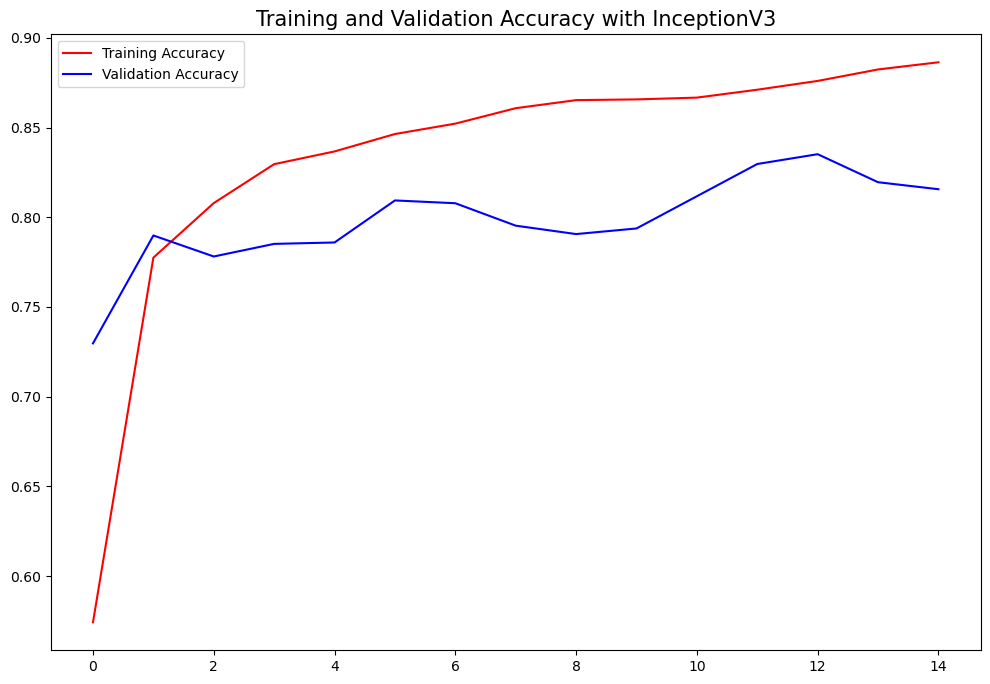

In [14]:
inception_acc = inception_history.history['accuracy']
inception_val_acc = inception_history.history['val_accuracy']

epochs = range(len(inception_acc))

plt.figure(figsize = (12, 8))
plt.plot(epochs, inception_acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, inception_val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy with InceptionV3', fontsize = 15)
plt.legend(loc = 0)

plt.show()

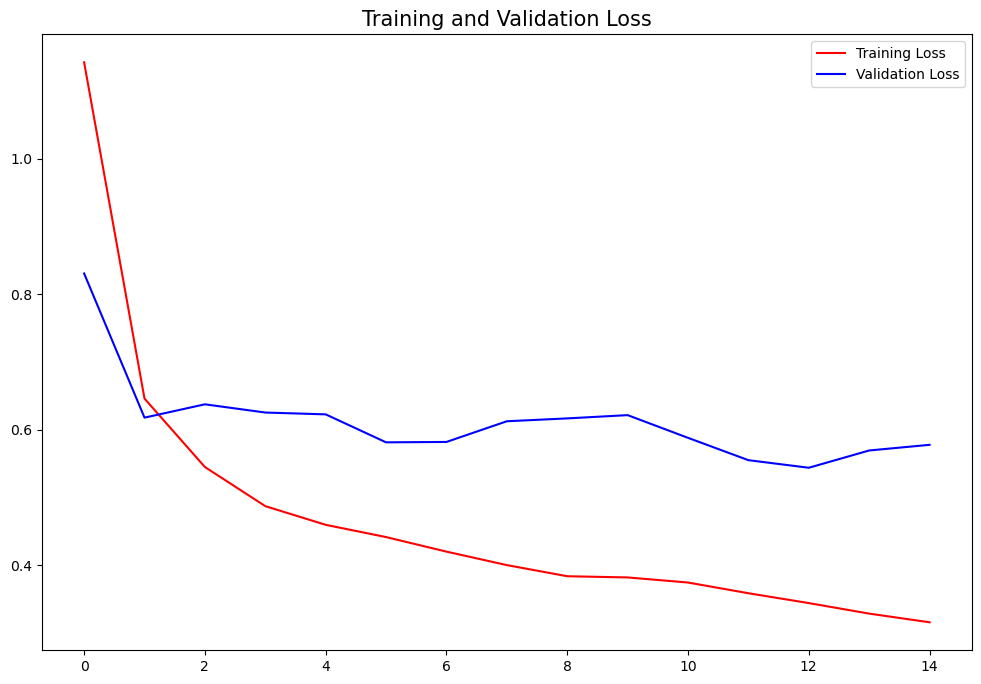

In [15]:
inception_loss = inception_history.history['loss']
inception_val_loss = inception_history.history['val_loss']

epochs = range(len(inception_loss))

plt.figure(figsize = (12, 8))
plt.plot(epochs, inception_loss, 'r', label = 'Training Loss')
plt.plot(epochs, inception_val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss', fontsize = 15)
plt.legend(loc = 0)

plt.show()

6/6 [==============================] - 16s 2s/step


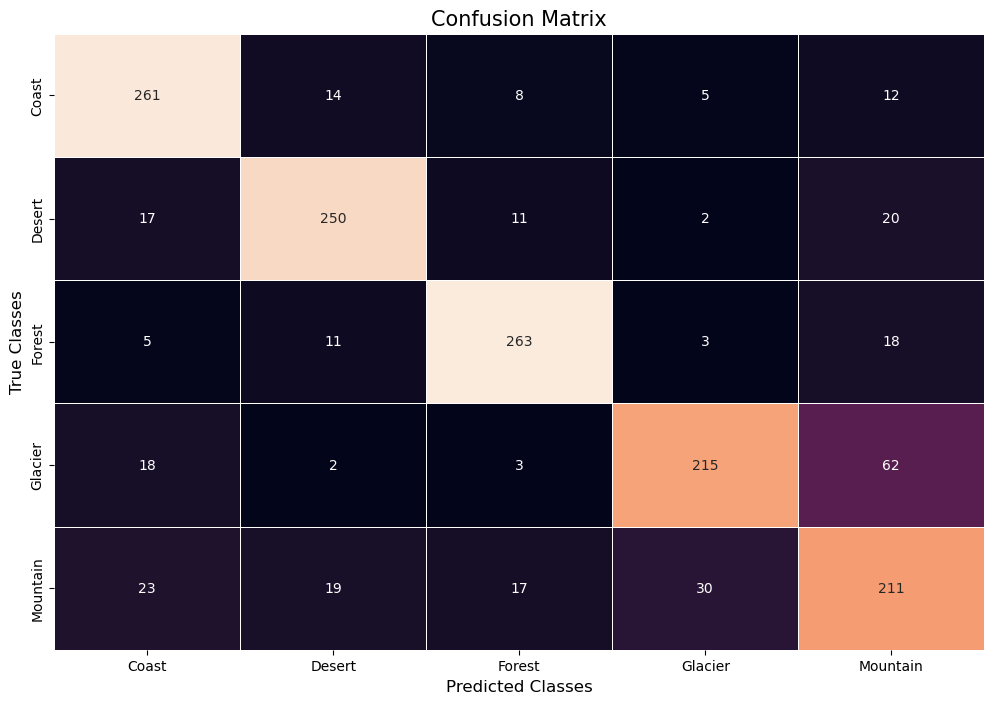

In [16]:
Y_pred_inception = inception_model.predict(validation_generator)
y_pred_inception = np.argmax(Y_pred_inception, axis = 1)

inception_confusion_matrix = confusion_matrix(validation_generator.classes, y_pred_inception)
conf_matrix = pd.DataFrame(data = inception_confusion_matrix, columns = labels, index = labels)

plt.figure(figsize = (12, 8))
sns.heatmap(conf_matrix, annot = True, cbar = False, fmt = 'd', linewidth = 0.5)
plt.xlabel('Predicted Classes', fontsize = 12)
plt.ylabel('True Classes', fontsize = 12)
plt.title('Confusion Matrix', fontsize = 15)
plt.show()

In [17]:
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_inception, target_names = labels))

Classification Report
              precision    recall  f1-score   support

       Coast       0.81      0.87      0.84       300
      Desert       0.84      0.83      0.84       300
      Forest       0.87      0.88      0.87       300
     Glacier       0.84      0.72      0.77       300
    Mountain       0.65      0.70      0.68       300

    accuracy                           0.80      1500
   macro avg       0.80      0.80      0.80      1500
weighted avg       0.80      0.80      0.80      1500



In [18]:
result = inception_model.evaluate(validation_generator, batch_size = 300)
print("Validation Loss & Accuracy:", result)

6/6 [==============================] - 14s 2s/step - loss: 0.6303 - accuracy: 0.8000
Validation Loss & Accuracy: [0.6302593350410461, 0.800000011920929]


1/1 [==============================] - 0s 56ms/step


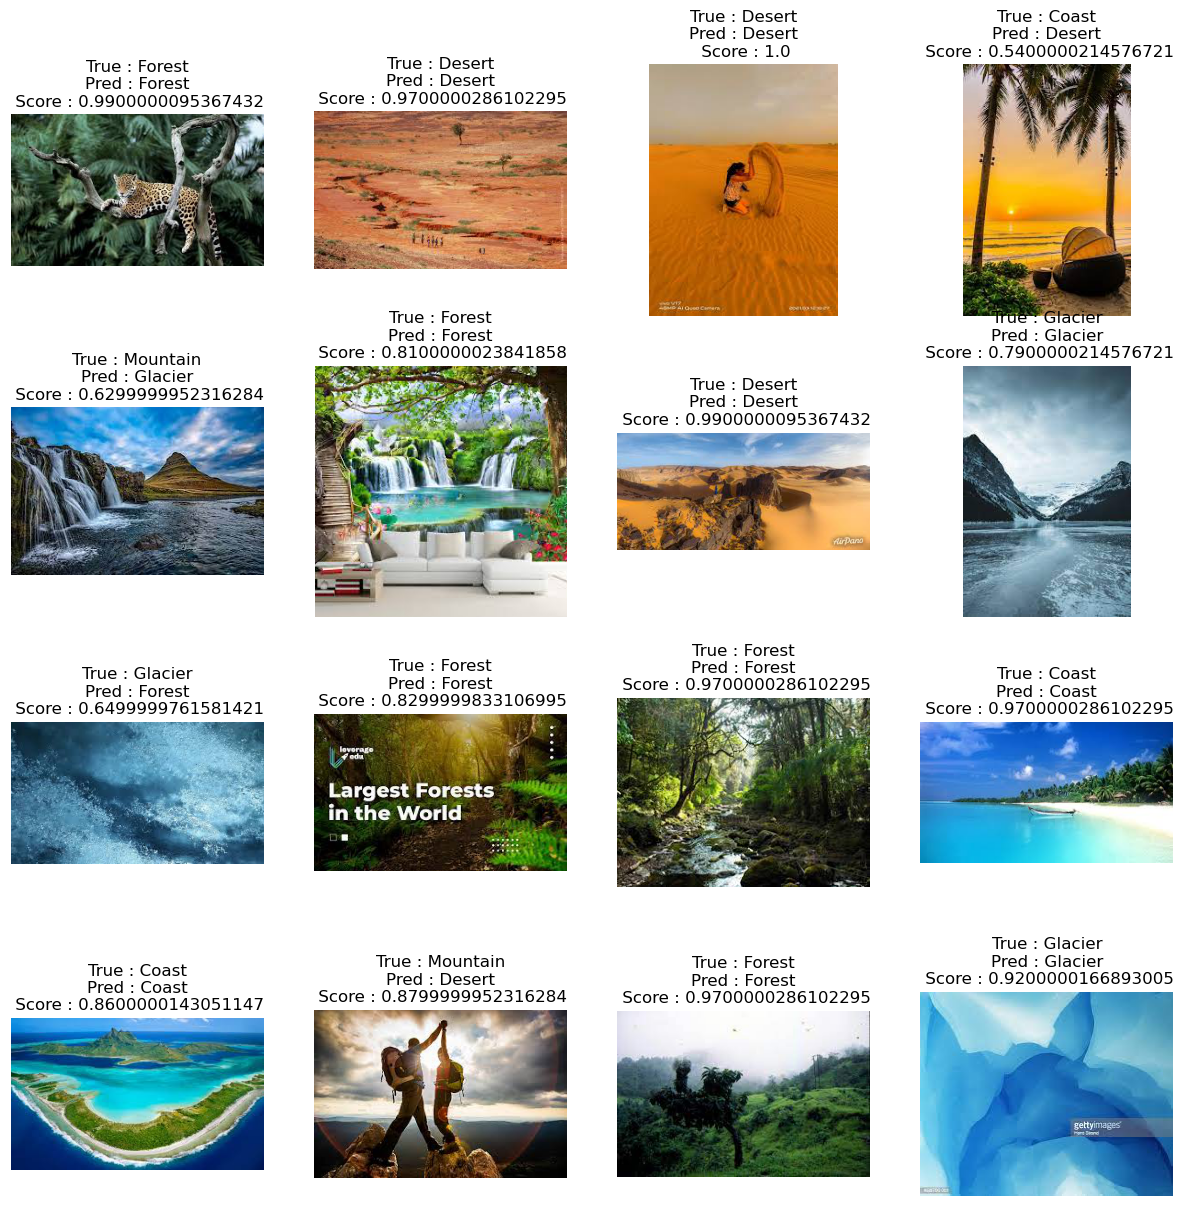

In [21]:
show_images(test_img_data, class_names=class_names, model=model, size=(15,15), GRID=(4, 4))